In [1]:
import pandas_datareader as pdr
import numpy as np
import datetime
import matplotlib.pyplot as plt
import yfinance as yf

# Define starting variables
SYMBOL = "^GSPC"
STARTING_BALANCE = 10000
PCT_THRESH = 20
down_days = 3  # Define number of consecutive down days for the strategy

# Define date range
START = datetime.datetime(2000, 1, 1)
END = datetime.datetime(2026, 1, 1)
YEARS = (END - START).days / 365.25

[*********************100%%**********************]  1 of 1 completed


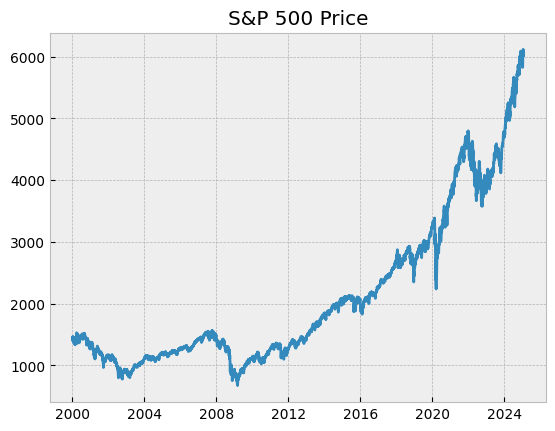

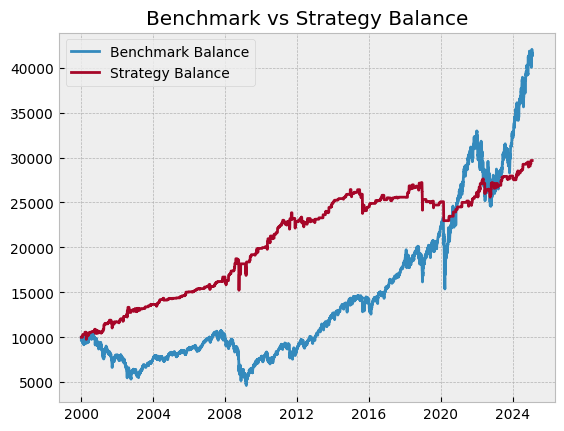

In [2]:
# Download historical data
price = yf.download(SYMBOL, start=START, end=END)

# Drop redundant columns
price = price.drop(['High', 'Low', 'Volume', 'Adj Close'], axis=1)

# Plot chart
plt.style.use('bmh')
plt.plot(price.Close)
plt.title('S&P 500 Price')
plt.show()

# Calculate return and balance
price['oc'] = price.Close / price.Open
price['cc'] = price.Close / price.Close.shift(1)
price.cc.iat[0] = 1
price['Bench_Bal'] = STARTING_BALANCE * price.cc.cumprod()

# Calculate benchmark drawdown
price['Bench_Peak'] = price.Bench_Bal.cummax()
price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak
bench_dd = round(((price.Bench_DD / price.Bench_Peak).min() * 100), 2)

# Calculate additional columns for strategy
price['Down'] = price.oc < 1  # Check if today is a down day

# Count consecutive down days
down = price['Down']
price['Consecutive'] = down * (down.groupby((down != down.shift()).cumsum()).cumcount() + 1)

# Identify entries and allocate trading fees
price['Long'] = price.Consecutive >= down_days  # Long signal after 'down_days' consecutive down days

# Calculate system return and balance
price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.cc, 1)
price['Sys_Bal'] = STARTING_BALANCE * price.Sys_Ret.cumprod()

# Plot results
plt.plot(price.Bench_Bal, label='Benchmark Balance')
plt.plot(price.Sys_Bal, label='Strategy Balance')
plt.legend(loc='best')
plt.title('Benchmark vs Strategy Balance')
plt.show()

In [4]:
# Calculate system drawdown
price['Sys_Peak'] = price.Sys_Bal.cummax()
price['Sys_DD'] = price.Sys_Bal - price.Sys_Peak
sys_dd = round(((price.Sys_DD / price.Sys_Peak).min()) * 100, 2)

bench_return = round(((price.Bench_Bal.iloc[-1] / price.Bench_Bal.iloc[0]) - 1) * 100, 2)
bench_cagr = round(((((price.Bench_Bal.iloc[-1] / price.Bench_Bal.iloc[0]) ** (1 / YEARS)) - 1) * 100), 2)
sys_return = round(((price.Sys_Bal.iloc[-1] / price.Sys_Bal.iloc[0]) - 1) * 100, 2)
sys_cagr = round(((((price.Sys_Bal.iloc[-1] / price.Sys_Bal.iloc[0]) ** (1 / YEARS)) - 1) * 100), 2)

sys_in_market = round((price.Long.value_counts().loc[True] / len(price)) * 100)
sys_win = price.Sys_Ret[price.Sys_Ret > 1.0].count()
sys_loss = price.Sys_Ret[price.Sys_Ret < 1.0].count()
sys_winrate = round(sys_win / (sys_win + sys_loss) * 100, 2)

# Print results
print(f'Benchmark Total return: {bench_return}%')
print(f'Benchmark CAGR: {bench_cagr}%')
print(f'Benchmark DD: {bench_dd}%')
print('')
print(f'System Total return: {sys_return}%')
print(f'System CAGR: {sys_cagr}%')
print(f'System DD: {sys_dd}%')
print(f'Time in Market: {sys_in_market}%')
print(f'Trades Won: {sys_win}')
print(f'Trades Loss: {sys_loss}')
print(f'Winrate: {sys_winrate}%')

# Define list of ETFs to backtest
symbols = ['^GSPC', '^DJI', '^IXIC', '^RUT', '^N225']

Benchmark Total return: 313.79%
Benchmark CAGR: 5.61%
Benchmark DD: -56.78%

System Total return: 196.73%
System CAGR: 4.27%
System DD: -18.72%
Time in Market: 9%
Trades Won: 329
Trades Loss: 220
Winrate: 59.93%


In [9]:

def backtest(symbol):
    # Download data using yfinance
    price = yf.download(symbol, start=START, end=END)
    
    # Drop redundant columns
    price = price.drop(['High', 'Low', 'Volume', 'Adj Close'], axis=1)
    
    # Calculate return and balance
    price['oc'] = price.Close / price.Open
    price['cc'] = price.Close / price.Close.shift(1)
    price.cc.iat[0] = 1
    price['Bench_Bal'] = STARTING_BALANCE * price.cc.cumprod()
    
    # Calculate benchmark drawdown
    price['Bench_Peak'] = price.Bench_Bal.cummax()
    price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak

    # Check if today is a down day
    price['Down'] = price.oc < 1

    # Count consecutive down days
    down = price['Down']
    price['Consecutive'] = down * (down.groupby((down != down.shift()).cumsum()).cumcount() + 1)
    
    price['Long'] = price.Consecutive >= down_days

    price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.cc, 1)
    price['Sys_Bal'] = STARTING_BALANCE * price.Sys_Ret.cumprod()
    
    # Calculate system drawdown
    price['Sys_Peak'] = price.Sys_Bal.cummax()
    price['Sys_DD'] = price.Sys_Bal - price.Sys_Peak
  
    # Calculate metrics using .iloc for position-based access
    bench_cagr = round(((((price.Bench_Bal.iloc[-1] / price.Bench_Bal.iloc[0]) ** (1 / YEARS)) - 1) * 100), 2)
    bench_dd = round((price.Bench_DD / price.Bench_Peak).min() * 100, 2)
    sys_cagr = round(((((price.Sys_Bal.iloc[-1] / price.Sys_Bal.iloc[0]) ** (1 / YEARS)) - 1) * 100), 2)
    sys_dd = round(((price.Sys_DD / price.Sys_Peak).min()) * 100, 2)
    
    return bench_cagr, sys_cagr, bench_dd, sys_dd

# Example: Call the backtest function for the S&P 500
bench_cagr, sys_cagr, bench_dd, sys_dd = backtest('^GSPC')

print(f"Benchmark CAGR: {bench_cagr}%")
print(f"System CAGR: {sys_cagr}%")
print(f"Benchmark Drawdown: {bench_dd}%")
print(f"System Drawdown: {sys_dd}%")



[*********************100%%**********************]  1 of 1 completed
Benchmark CAGR: 5.61%
System CAGR: 4.27%
Benchmark Drawdown: -56.78%
System Drawdown: -18.72%


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


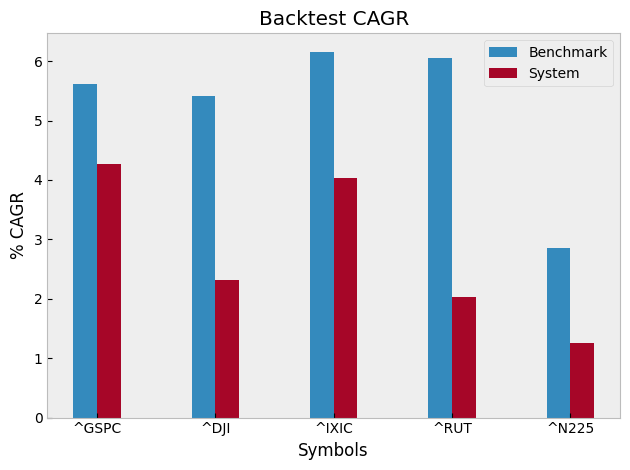

In [10]:
# Initialize empty lists to store CAGR values
bc = []
sc = []

# Loop over the symbols
for symbol in symbols:
    try:
        bench_cagr, sys_cagr, _, _ = backtest(symbol)  # Make sure to capture all the metrics
        bc.append(bench_cagr)
        sc.append(sys_cagr)
    except Exception as e:
        print(f"Error backtesting {symbol}: {e}")
        bc.append(None)
        sc.append(None)

# Plot data
x_indices = np.arange(len(symbols))
width = 0.2

plt.bar(x_indices - width / 2, bc, width=width, label='Benchmark')
plt.bar(x_indices + width / 2, sc, width=width, label='System')

plt.xticks(ticks=x_indices, labels=symbols)

plt.legend()

plt.title('Backtest CAGR')
plt.xlabel('Symbols')
plt.ylabel('% CAGR')
plt.tight_layout()

plt.grid(False)

# Save and display the plot
plt.savefig('saved_figure.png', dpi=500)
plt.show()